# Analyzing the NYC Subway Dataset

In this project, I used statistical methods to figure out whether more people in NYC ride the subway when it is raining versus when it is not raining. Then we use data visualization to draw some interesting conclusions about the subway dataset.


In [497]:
#the NYC subway dataset   
%matplotlib inline
import pandas as pd
from pandas import *
turnstile_master = pd.read_csv('turnstile_data_master_with_weather.csv')
turnstile_master.head(10)

,Unnamed: 0,UNIT,DATEn,TIMEn,Hour,DESCn,ENTRIESn_hourly,EXITSn_hourly,maxpressurei,maxdewpti,...,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
0,0,R001,2011-05-01,01:00:00,1,REGULAR,0,0,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
1,1,R001,2011-05-01,05:00:00,5,REGULAR,217,553,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
2,2,R001,2011-05-01,09:00:00,9,REGULAR,890,1262,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
3,3,R001,2011-05-01,13:00:00,13,REGULAR,2451,3708,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
4,4,R001,2011-05-01,17:00:00,17,REGULAR,4400,2501,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
5,5,R001,2011-05-01,21:00:00,21,REGULAR,3372,2122,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
6,6,R002,2011-05-01,01:00:00,1,REGULAR,0,0,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
7,7,R002,2011-05-01,05:00:00,5,REGULAR,42,66,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
8,8,R002,2011-05-01,09:00:00,9,REGULAR,50,125,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
9,9,R002,2011-05-01,13:00:00,13,REGULAR,316,716,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0


# Section 1. Statistical Test

## 1.1 Statistical Test

Mann-Whitney U-Test is used to analyze the NYC subway data with two-tail P-value. 

The null hypothesis asserts that the distributions of both riderships on rainy and non-rainy day are identical.

Level of significance in Mann-Whitney U-Test is 5% (so p-critical value = 0.05)

Because the obtained p-value from scipy.stats.mannwhitneyu is for a one-tailed hypothesis, to get the two-tailed p-value multiply the returned p-value by 2 as noted in this link : http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mannwhitneyu.html 

## 1.2 Statistical Test Applicability

The dataset of hourly entries to MTA turntiles is separated by two different groups (riderships on rainy and non-rainy days). The Mann-Whitney U-test will check that the medians of two non-normal distributions are equal (null hypothesis). 
The distribution of riderships on rainy and non-rainy days are not normal shape (Gaussian Distribution), so it is appropriate to apply the Mann-Whitney U test to determine whether there is any statistically significant difference in the distributions of two groups. For more details is here: http://www.alglib.net/hypothesistesting/mannwhitneyu.php 

## 1.3 Test Results

Here is the result from this statistical test.

In [498]:
import numpy as np
import scipy
import scipy.stats

turnstile_rain = turnstile_master[turnstile_master['rain'] == 1]
turnstile_no_rain = turnstile_master[turnstile_master['rain'] == 0]
    
#with_rain_mean = np.mean(turnstile_rain['ENTRIESn_hourly']) 
#without_rain_mean = np.mean(turnstile_no_rain['ENTRIESn_hourly'])

with_rain_mean = turnstile_rain['ENTRIESn_hourly'].mean() 
without_rain_mean = turnstile_no_rain['ENTRIESn_hourly'].mean() 

print 'mean number of entries on rainy days: {0}\nmean number of entries non-rainy days: {1}\n'.format(with_rain_mean, without_rain_mean)
    
U,p  = scipy.stats.mannwhitneyu(turnstile_rain['ENTRIESn_hourly'],turnstile_no_rain['ENTRIESn_hourly'], use_continuity=True)
print 'Mann-Whitney U-test: {0}\np-Value: {1}'.format(U,p)



mean number of entries on rainy days: 1105.44637675
mean number of entries non-rainy days: 1090.27878015

Mann-Whitney U-test: 1924409167.0
p-Value: 0.0249999127935


## 1.4 Test Significance

In [499]:
significance_level = 0.05

#two-tailed test, multiply the returned p-value by 2
if p*2 <= significance_level:
    print 'Reject the null hypothesis'
else:
    print 'Retain the null hypothesis'

Reject the null hypothesis


We note that p-value of this statistical test is smaller than 0.05 , so we can confidently reject the null hypothesis. In other word, the distribution of two samples is significantly diferrent. 

Reference is http://psych.unl.edu/psycrs/handcomp/hcmann.PDF

# Section 2. Linear Regression

## 2.1 Prediction model

OLS (Ordinary Least Squares) using Statsmodels is used to compute the coefficients theta and produce prediction for ENTRIESn_hourly in my regression model.

Reference is https://en.wikipedia.org/wiki/Ordinary_least_squares

## 2.2 Feature Selection

The following features are extracted from the dataset :

    * rain 
    * precipi 
    * Hour 
    * meantempi 

In [501]:
# features selection
features = turnstile_master[['rain', 'meantempi','precipi', 'Hour']]

Create a new feature from dataset :
    * precipi_sqrt is square root of precipi in dataset

In [502]:
# needed to prevent warning about chained assignment
features.is_copy = False 

# create polynomial features
features['precipi_sqrt'] = turnstile_master['precipi']**0.5

Dummy variable is used as feature in the regression model. The dummy variable is UNIT variable in dataset. 

In [503]:
# add dummy as features in the model
dummy_units = pd.get_dummies(turnstile_master['UNIT'], prefix='unit')
features = features.join(dummy_units)

## 2.3 Feature Selection Rationale

People will choose to use public transportation in the inconvenient weather conditions such as rain, precipitation, average temperature to reduce the risk of traffic congestion. Thus these components are definitely used as features to predict the riders' decision making to take public trasportation.

precipi_sqrt is used to enhance the R-squared value. Hour is selected because we can see how ridership varies with time of day.



## 2.4 Model parameters

In [504]:
import statsmodels.api as sm

# Perform linear regression given a data set with an arbitrary number of features.
def linear_regression(features, values):
  
    features = sm.add_constant(features)
    model = sm.OLS(values,features)
    results = model.fit()
    
    intercept = results.params[0]
    params = results.params[1:]
    rsquared = results.rsquared
    #print results.summary()
    return intercept, params, rsquared


# Ridership Values
values = turnstile_master['ENTRIESn_hourly']

# Perform linear regression
intercept, params, rsquared = linear_regression(features, values)


print 'The intercept of the linear regression : {0}\n'.format(intercept)
print 'The coefficients of the linear regression : \n{0}\n'.format(params[:5])
print 'The R2 value : {0}\n'.format(rsquared)

The intercept of the linear regression : 1377.19856309

The coefficients of the linear regression : 
rain            253.447152
meantempi        -8.164409
precipi         522.995807
Hour             67.383287
precipi_sqrt   -841.033474
dtype: float64

The R2 value : 0.45834136127



## 2.5 R-Squared value

In [505]:
# prediction value from the regression model
predictions = intercept + np.dot(features, params)

# Total sum of squares
SST = ((values-np.mean(values))**2).sum()

# Regression sum of squares
SSReg = ((predictions-np.mean(values))**2).sum()

# calculate R2 (coefficients of determination) value.
r_squared = SSReg / SST

print 'The R2 value : {0}\n'.format(r_squared)

The R2 value : 0.45834136127



Reference this to calculate R2 Squared : https://en.wikipedia.org/wiki/Coefficient_of_determination

## 2.6 Goodness of fit 

The higher R-squared , the better a model fits the data. That means a higher R-squared is required for precision prediction. In this case, R-squared is rather low (45%) , so the linear regression model seems inappropriate for predicting ridership. However, R-squared does not neccesarily indicate that  a regression model is adequate or not. Sometimes we can have a low R-squared value for a good model, or a high R-squared value for a model that does not fit the data. 

Based on R-squared, I can explain about 45% of the data variablity with the OLS model. In other word, my model lets me predict the entry per hour in NYC subway with 45% accuracy. 

The 95% confidence interval for the slope in respect with independent variable 'rain' is the estimated coefficient 185.875 and 321.020

Reference: http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit



# Section 3. Visualization

## 3.1 ENTRIESn_hourly for rainy days and non-rainy days.

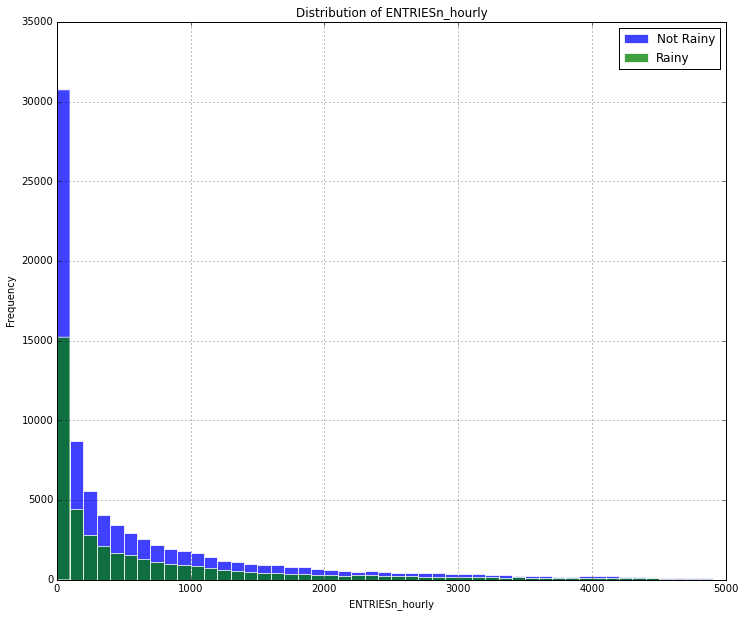

In [506]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D 

from ggplot import *

num_bins = 50
start_bin = min(turnstile_master['ENTRIESn_hourly'])
stop_bin = 5000 
bin_width = (stop_bin - start_bin)/num_bins

bin_list = np.arange(start_bin, stop_bin, bin_width)

plt.figure(figsize=(16,12))
histx = turnstile_master[turnstile_master.rain == 0]['ENTRIESn_hourly'].plot(kind='hist', 
                                                                          bins = bin_list,
                                                                          figsize=(12, 10),
                                                                          edgecolor='w',
                                                                          label='Not Rainy', 
                                                                          alpha = 0.75)

histx = turnstile_master[turnstile_master.rain == 1]['ENTRIESn_hourly'].plot(kind='hist', 
                                                                          bins = bin_list,
                                                                          figsize=(12, 10),
                                                                          edgecolor='w',
                                                                          label='Rainy',
                                                                          alpha = 0.75)
histx.grid()
histx.legend()
histx.set_ylabel('Frequency')
histx.set_xlabel('ENTRIESn_hourly')
histx.set_title('Distribution of ENTRIESn_hourly')

The above histogram shows that the distribution of ridership on rainy and non-rainy days are not normal shape. There are much fewer observations on rainy days than not rainy days.

## 3.2 Ridership by day-of-week

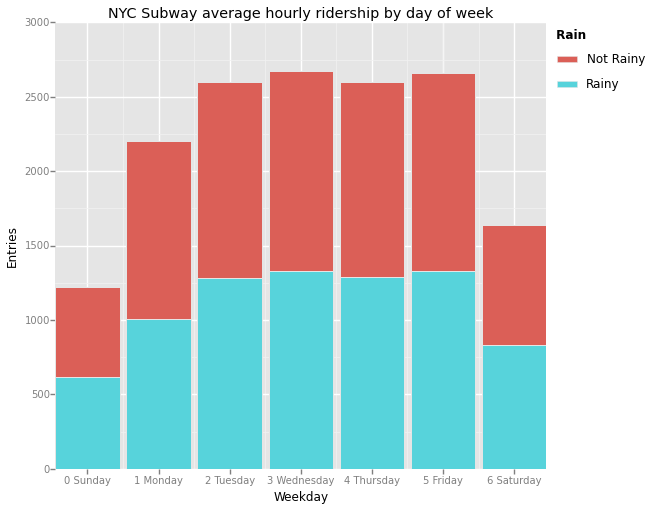

<ggplot: (307256169)>


In [507]:
from ggplot import *
from datetime import *
''' 
Ridership by time-of-day or day-of-week   
https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv
'''
#df =  turnstile_master.groupby(['weather', 'Hour'], as_index=False).mean()

EntriesByDayOfMonth = turnstile_master[['DATEn', 'ENTRIESn_hourly', 'rain']] \
                     .groupby('DATEn', as_index=False).mean()

EntriesByDayOfMonth['Day'] = [datetime.strptime(x, '%Y-%m-%d') \
                             .strftime('%w %A') for x in EntriesByDayOfMonth['DATEn']]

EntriesByDay = EntriesByDayOfMonth[['Day', 'ENTRIESn_hourly', 'rain']] \
               .groupby(['rain','Day'], as_index=False).mean()

map_dict = {0: 'not rainy', 1: 'rainy'}
EntriesByDay['rain'] = EntriesByDay['rain'].map(map_dict)

plot = ggplot(aes(x='Day', fill = 'rain'),data = EntriesByDay) \
    + geom_histogram(aes(weight = 'ENTRIESn_hourly')) \
    + ggtitle('NYC Subway average hourly ridership by day of week') \
    + xlab('Weekday') + ylab('Entries')
print plot

The bar chart shows the average hourly ridership in NYC subway and it indicates that more people ride the subway on the weekdays than weekends.

## 3.3 Ridership by hour

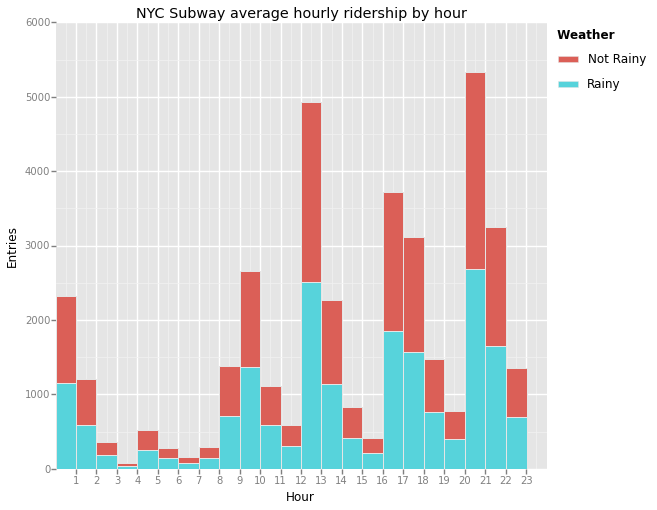

<ggplot: (307251169)>


In [508]:
map_dict = {0: 'not rainy', 1: 'rainy'}
turnstile_master['weather'] = turnstile_master['rain'].map(map_dict)

df =  turnstile_master.groupby(['weather', 'Hour'], as_index=False).mean()

plot = ggplot(aes(x='Hour', fill = 'weather'),data = df) \
    + geom_histogram(aes(weight = 'ENTRIESn_hourly'),binwidth=1) \
    + scale_x_continuous(limits = (0,24), breaks = range(1,24)) \
    + ggtitle('NYC Subway average hourly ridership by hour') \
    + xlab('Hour') + ylab('Entries')


print plot

The bar chart shows the average hourly ridership in NYC subway by hour and it indicates that more people ride the subway on the not rainy day than rainy day. Furthermore, more people take MTA in the rush hours (such as 9am, 12pm, 16pm and 20pm)

# Section 4. Conclusion

## 4.1 Ridership in the NYC subway when it is raining or when it is not raining

Based on analysis and visualization of the data, more people ride
the NYC subway when it is raining. 

On average, between 15 and 253 more people ride the NYC subway on a rainy day compared to a non-rainy day. These numbers come from using simple mean comparison, and linear regressions with OLS. In the mean comparison, there is a difference of 15 entries per hour, while in the OLS model the theta for the rain variable was 253. 


## 4.2 Rationale

Based on the Mann-Whitney U-test, the distributions of rainy days and non-rainy days are different, i.e mean hourly entries on rainy days is greater than non-rainy days in [Section 1.3](#1.3-Test-Results) (1105 vs 1090). In other words,  subway usage increases  by 15 riders per hour when it rains.


Furthermore, as seen in [Section 2.4](#2.4-Model-parameters) given that the rain variable is a boolean the interpretation of the theta is that when it rains (rain = 1), positive correlation coefficient of variable 'rain' indicates 253 more people will use subway when it is raining.


The comparison of both means using the Mann-Whitney U-test gives me good reason to believe that there is a statistical significant difference between the two data distributions. While positive theta of rain feature in the OLS models verifies my assumption.


# Section 5. Reflection

## 5.1 The shortcomings of the methods

The Ordinary Least Squares method suffers from the major pitfall that it attempts to fit a line through one dimensional data sets, or a hyperplane through higher dimensional datasets. In reality though, most problems are non-linear relationships. Even with an infinite amount of training points, linear method will often fail to make a good prediction. 

Another problem with this MTA data is that it consists of a lot independent variables and if I choose too many features, that will lead to a worse prediction. So keeping some useful dependent variables and discarding the other ones are also important to reduce the computational and storage capacities. That approach can be solved by feature selection methods like PCA, ICA. This model consists a lot of dummy variables which increases the chance of multicollinearity.

Furthermore, the dataset provided contains only MTA data in May which may affect the accuracy for ridership prediction.

Reference is http://www.clockbackward.com/2009/06/18/ordinary-least-squares-linear-regression-flaws-problems-and-pitfalls/